In [368]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [369]:
df = pd.read_csv("https://raw.githubusercontent.com/mpipatta/mpipatta.github.io/master/testdata/load_temp2016.csv")

In [370]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 5 columns):
month    8784 non-null int64
day      8784 non-null int64
hh       8784 non-null int64
load     8784 non-null float64
Temp     8784 non-null int64
dtypes: float64(1), int64(4)
memory usage: 343.2 KB


,month,day,hh,load,Temp
0,1,1,0,4.3000,74
1,1,1,1,4.1200,0
2,1,1,2,4.0625,0
3,1,1,3,4.4375,0
4,1,1,4,3.8750,0


In [371]:
df['Year']='2016'

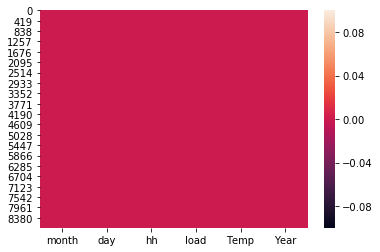

In [372]:
sns.heatmap(df.isnull())

In [373]:
def toDateTime(columns):
    month=columns['month']
    day=columns['day']
    hour=columns['hh']
    year=columns['Year']

    return pd.to_datetime(str(year)+"-"+str(month)+"-"+str(day)+" "+str(hour)+":00")

In [374]:
df['DateTime']=df.apply(toDateTime,axis=1)
df.drop(['month','day','Year','hh'],axis=1,inplace=True)

In [375]:
df.dtypes

load               float64
Temp                 int64
DateTime    datetime64[ns]
dtype: object

In [376]:
df.isnull().sum()

load        0
Temp        0
DateTime    0
dtype: int64

In [377]:
df.set_index('DateTime',inplace=True)

In [378]:
df.describe()

,load,Temp
count,8784.00000,8784.000000
mean,18.27804,83.663365
std,18.76574,12.129081
min,0.00000,0.000000
25%,6.00000,82.000000
50%,8.81250,85.000000
75%,27.50000,89.000000
max,104.25000,100.000000


## Removing 0 values

In [380]:
df['Temp']=df['Temp'].apply(lambda x:np.nan if x==0 else x)
df['load']=df['load'].apply(lambda x:np.nan if x==0 else x)

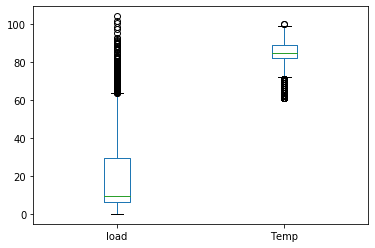

In [381]:
df[['load','Temp']].plot(kind='box')

In [382]:
df['Temp']=df['Temp'].apply(lambda x:(x-32)*5/9)

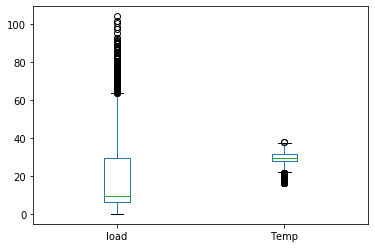

In [383]:
df[['load','Temp']].plot(kind='box')

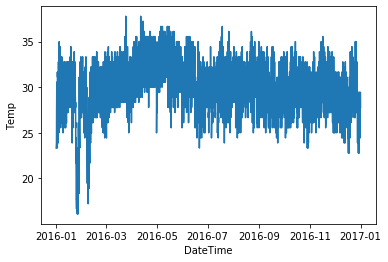

In [386]:
sns.lineplot(df.index,df['Temp'])

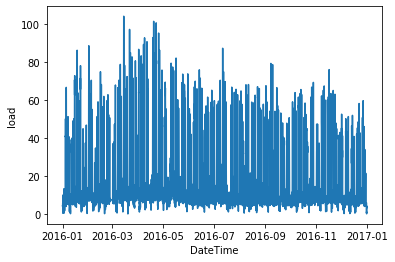

In [387]:
sns.lineplot(df.index,df['load'])

In [388]:
df.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)

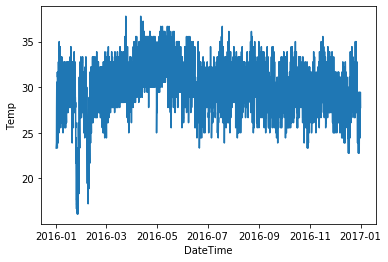

In [389]:
sns.lineplot(df.index,df['Temp'])

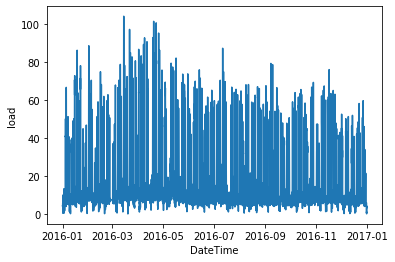

In [390]:
sns.lineplot(df.index,df['load'])

In [406]:
dayofweek=df.index.dayofweek

In [416]:
df['dow']=dayofweek

In [417]:
df['dow'].value_counts()

5    1272
4    1272
6    1248
3    1248
2    1248
1    1248
0    1248
Name: dow, dtype: int64

In [425]:
df.head()

,load,Temp,dow
DateTime,,,
2016-01-01 00:00:00,4.3000,23.333333,4
2016-01-01 01:00:00,4.1200,23.402778,4
2016-01-01 02:00:00,4.0625,23.472222,4
2016-01-01 03:00:00,4.4375,23.541667,4
2016-01-01 04:00:00,3.8750,23.611111,4


In [437]:
df.reset_index(inplace=True)
df['daytime']=df['DateTime'].apply(lambda x : 1 if (x.hour>=8 and x.hour<=18 and x.dayofweek<5) else 0)
df.set_index('DateTime',inplace=True)
df.drop('index',inplace=True,axis=1)

In [438]:
df

,load,Temp,dow,daytime
DateTime,,,,
2016-01-01 00:00:00,4.300000,23.333333,4,0
2016-01-01 01:00:00,4.120000,23.402778,4,0
2016-01-01 02:00:00,4.062500,23.472222,4,0
2016-01-01 03:00:00,4.437500,23.541667,4,0
2016-01-01 04:00:00,3.875000,23.611111,4,0
...,...,...,...,...
2016-12-31 19:00:00,3.491379,28.888889,5,0
2016-12-31 20:00:00,3.250000,28.333333,5,0
2016-12-31 21:00:00,3.500000,27.777778,5,0


In [439]:
df[(df['daytime']==0)&(df['load']>=40)]

,load,Temp,dow,daytime
DateTime,,,,
2016-04-07 07:00:00,42.7500,29.444444,3,0
2016-11-23 06:00:00,41.7500,28.333333,2,0
2016-11-23 07:00:00,44.4375,27.777778,2,0


In [440]:
len(df[df['Temp']>30])

3385

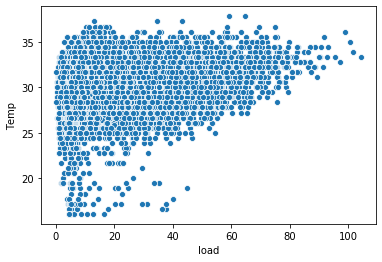

In [441]:
sns.scatterplot(x='load',y='Temp',data=df)